In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np, yaml, cPickle as pickle
import data_io
import pandas as pd

golden = False

In [2]:
train_files, test_files = data_io.load_splits(test_fold=0, large_data=True)

In [3]:
# load richness file
richness = pd.read_csv(data_io.large_base + 'other_annots/allSpeciesRichness.csv')
fname_to_rich = {}
for fname, rich in zip(richness['Filename'], richness['birdSpeciesRichness']):
    fname_to_rich[fname.replace('.wav', '.pkl')] = rich
    
train_files = [xx for xx in train_files if xx in fname_to_rich]
test_files = [xx for xx in test_files if xx in fname_to_rich]

In [4]:
# load in all spectrograms plus ground truth biotic annotations
train_specs, train_annots = data_io.load_data(
    train_files, 'mel', False, 'biotic', 0.001, 10.0, is_golden=False)
test_specs, test_annots = data_io.load_data(
    test_files, 'mel', False, 'biotic', 0.001, 10.0, is_golden=False)
# fname_to_spec = {fname: spec for fname, spec in zip(train_files, all_specs)}

/media/michael/Engage/data/audio/alison_data/large_dataset/annots/CR8-13548_20130921_1528.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/W84LA-013548_20130627_2326.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/E105JP-13548_20131013_0916.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/NW1-013527_20130701_0804.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/W84LA-013548_20130624_1901.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/E105JP-13548_20131011_1352.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/NW1-013527_20130625_0801.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/W112NN-13548_20130712_0355.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/W84LA-013548_20130626_2005.pkl
/media/michael/Engage/data/audio/alison_data/large_dataset/annots/NW1-013527_20130626_0521.pkl
/media/michael/Engage/data/audio/alison

/home/michael/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:549: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [5]:
print len(train_files), len(test_files)
print len(richness)

250 125
375


In [75]:
def compute_ACI(spectro,j_bin):
    """
    Compute the Acoustic Complexity Index from the spectrogram of an audio signal.
    Reference: Pieretti N, Farina A, Morri FD (2011) A new methodology to infer the singing activity of an avian community: the Acoustic Complexity Index (ACI). Ecological Indicators, 11, 868-873.
    Ported from the soundecology R package.
    spectro: the spectrogram of the audio signal
    j_bin: temporal size of the frame (in samples)
    """

    #times = range(0, spectro.shape[1], j_bin) # relevant time indices
    times = range(0, spectro.shape[1]-10, j_bin) # alternative time indices to follow the R code

    jspecs = [np.array(spectro[:,i:i+j_bin]) for i in times]  # sub-spectros of temporal size j

    aci = [sum((np.sum(abs(np.diff(jspec)), axis=1) / np.sum(jspec, axis=1))) for jspec in jspecs] 	# list of ACI values on each jspecs
    main_value = sum(aci)
    temporal_values = aci

    return main_value, temporal_values # return main (global) value, temporal values

def ACI_inspired_features(spec):
    return np.abs(np.diff(spec)).sum(axis=1)# / np.sum(spec, axis=1)


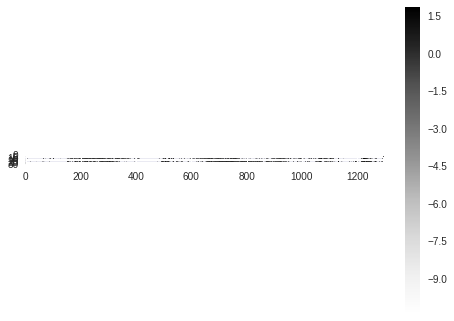

In [76]:
plt.imshow(np.log(train_specs[0]))
plt.colorbar()

In [97]:
from copy import copy
def compute_features(_spec, annot):
    spec = copy(_spec)
    spec -= np.median(spec, 1, keepdims=True)
    just_biotic_normed = spec[:, annot > 0.5]
    just_biotic_unnormed = _spec[:, annot > 0.5]
    
#     print just_biotic_unnormed.shape
    
    if just_biotic_normed.size == 0:
        return np.zeros(33)
    X = []
#     X.append(just_biotic_normed.mean(1))
#     X.append(just_biotic_unnormed.std(1))
#     X.append(just_biotic_unnormed.mean(1))
#     X.append(just_biotic_unnormed.std(1))
    X.append(just_biotic_unnormed.shape[1])
    X.append(ACI_inspired_features(just_biotic_unnormed))
    tmp = np.hstack(X)
    return tmp


train_X = []
for spec, annot in zip(train_specs, train_annots):
    train_X.append(compute_features(spec, annot))
train_X = np.vstack(train_X)
train_y = np.array([fname_to_rich[fname] for fname in train_files])


test_X = []
for spec, annot in zip(test_specs, test_annots):
    test_X.append(compute_features(spec, annot))
test_X = np.vstack(test_X)
test_y = np.array([fname_to_rich[fname] for fname in test_files])

print train_X.shape, train_y.shape, test_X.shape, test_y.shape

(250, 33) (250,) (125, 33) (125,)


In [98]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(25, max_depth=10)
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)

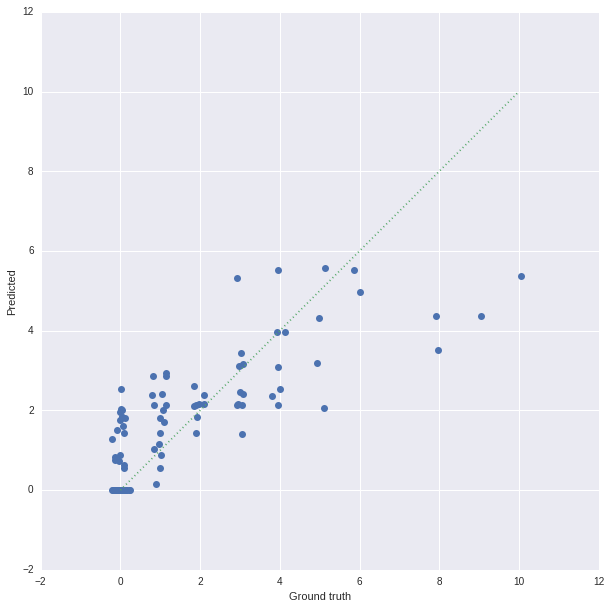

In [99]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plt.plot(test_y + np.random.randn(test_y.shape[0]) * 0.1 , pred_y, 'o')
plt.xlabel('Ground truth')
plt.ylabel('Predicted')
plt.axis('equal')
plt.plot([0, 10], [0, 10], ':')

In [100]:
from sklearn.metrics import *
for met in [mean_absolute_error, mean_squared_error, median_absolute_error, r2_score]:
    print met(test_y, pred_y)

0.674924444444
1.42233451812
0.141333333333
0.666936773586


In [85]:
# Using mel32:
0.76416
1.85260214044
0.28
0.566182470934


# mel64
0.773277040854
1.90792352389
0.164210526316
0.553228051123

# just scalar
0.739294679908
1.68940084081
0.273333333333
0.604398763037

# scalar + ACI inspired features
0.674924444444
1.42233451812
0.141333333333
0.666936773586

0.604398763037

In [86]:
lengths = []
for spec, annot in zip(test_specs, test_annots):
    lengths.append(annot.sum())
lengths = np.array(lengths)
richnesses = np.array([fname_to_rich[fname] for fname in test_files])

print lengths[richnesses == 0]

[   0.            0.           44.            0.          457.00732422
    0.            0.            0.           24.          229.9984436     0.
    0.            0.            0.           45.            0.            0.
    0.            0.          279.97674561    0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.          158.            0.            0.            0.
    0.            0.            0.            0.            0.            0.
    0.            0.          122.            0.            0.            0.
  134.00671387  174.98684692    0.            0.           63.
    8.99960899    0.            0.            0.            0.            0.
    0.            0.            0.           25.          793.99285889
    0.            0.           58.           54.            0.            0.
    0.           13.            0.            0.           98.        ]
